In [1]:
import os
import numpy as np
import torch
import pickle
import time

import torch
from torch.utils.data import DataLoader, Dataset
from models import Pose2AudioTransformer
from transformers import EncodecModel
from utils import DanceToMusic
from datetime import datetime
from torch.optim import Adam

/Users/azeez/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# assign GPU or CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device = torch.device("cpu")

model_id = "facebook/encodec_24khz"
encodec_model = EncodecModel.from_pretrained(model_id)
codebook_size = encodec_model.quantizer.codebook_size
sample_rate = 24000

# data_dir = "/Users/azeez/Documents/pose_estimation/Learning2Dance/l2d_train_3D"
data_dir = "/Users/azeez/Documents/pose_estimation/Learning2Dance/youtube_dataset/dataset/samples"
dataset = DanceToMusic(data_dir, encoder = encodec_model, sample_rate = sample_rate, device=device)

/Users/azeez/miniforge3/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

encodings = []
for audio_codes, pose, pose_mask, wav, wav_mask, _, _ in dataset:
    encodings.append(audio_codes.reshape(1,-1)[0].numpy())

encodings = np.array(encodings)
pca = PCA(n_components=2)
pca.fit(encodings)

components = pca.components_
for i, component in enumerate(components):
    print(f"Principal Component {i+1}")
    
    # Sort the loadings by magnitude and get the indices
    sorted_idx = np.argsort(np.abs(component))[::-1]
    
    # Print the features with highest loadings (You can choose to print a subset, e.g., top 10)
    for idx in sorted_idx[:10]:
        print(f"Feature {idx}, Loading {component[idx]}")

Principal Component 1
Feature 179, Loading 0.07184610023951908
Feature 420, Loading 0.07097287462603473
Feature 162, Loading 0.06897261262936613
Feature 266, Loading 0.0686912659597452
Feature 829, Loading 0.06536970909899077
Feature 181, Loading 0.06188046130253763
Feature 123, Loading 0.061544187490386024
Feature 79, Loading 0.060667326167426726
Feature 360, Loading 0.060402710368006096
Feature 416, Loading 0.059593982334214896
Principal Component 2
Feature 751, Loading -0.08263757467970276
Feature 1462, Loading -0.08102425897609093
Feature 1323, Loading -0.08062653584117842
Feature 406, Loading 0.080202720155235
Feature 757, Loading -0.07949331211112147
Feature 987, Loading -0.07118482764987827
Feature 1142, Loading -0.0700366406601887
Feature 767, Loading -0.06990969369109354
Feature 696, Loading 0.06888973249834683
Feature 635, Loading 0.06884107551341052


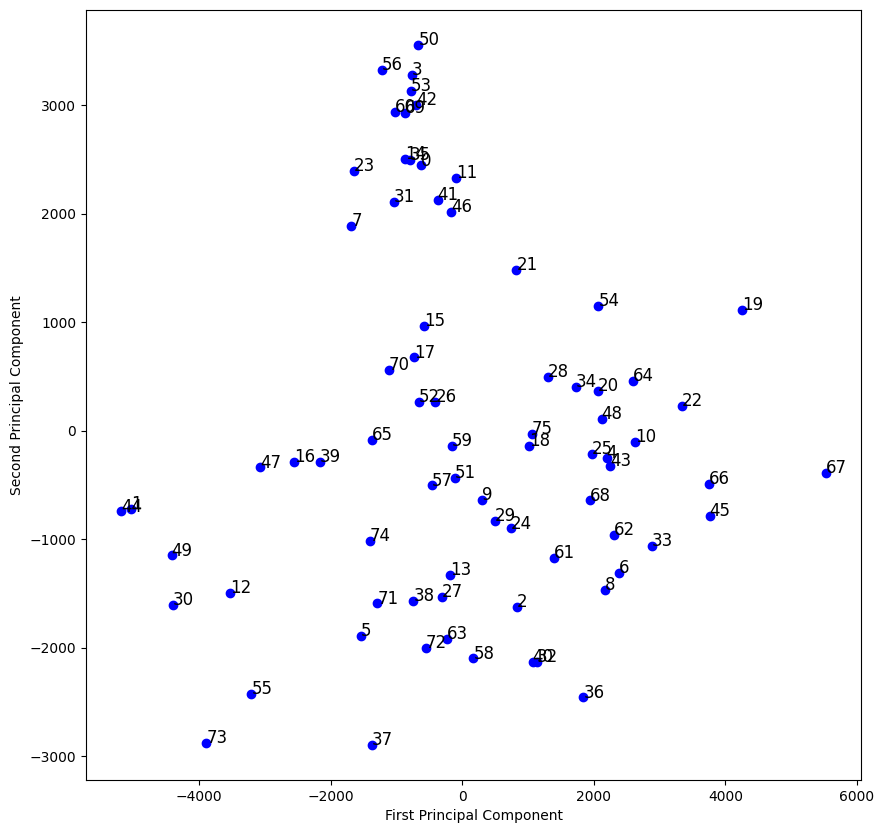

In [4]:
# Transform the original encodings into 2D
encodings_2d = pca.transform(encodings)

# Extract the x and y coordinates
x_coords = encodings_2d[:, 0]
y_coords = encodings_2d[:, 1]

# Create the scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(x_coords, y_coords, c='blue')

# Optional: Annotate each point with its index
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.text(x, y, str(i), fontsize=12)

# Label the axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Show the plot
plt.show()

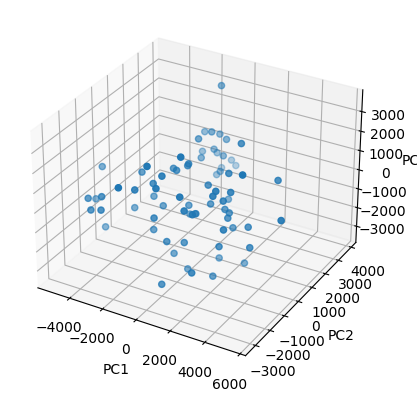

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Fit the PCA model
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(encodings)

# Extract the coordinates of transformed points
x = transformed_data[:, 0]
y = transformed_data[:, 1]
z = transformed_data[:, 2]

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

# Label axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Show the plot
plt.show()